                                                                                MACHINE LEARNING

Lo primero que se debe de hacer es un centrado y escalado de los datos, eliminando previamente datos que no necesito para ML:

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
#Dataframe para predecir

games = pd.read_csv("data/games_clean.csv")

games_ml = games.iloc[:, -56:]
games_ml['Duration'] = games.gameDuration
columnas = games_ml.columns

#Mi variable a predecir (target)

winner_ml = games.iloc[:, 3]

In [3]:
# Ahora el primer paso es convertir todas las variables de campeones y spells a dummies, puesto que son texto

games_ml = pd.get_dummies(games_ml)

# Ahora que lo tengo tengo que hacer el centrado y escalado para evitar condicionar a la red con valores grandes

from sklearn.preprocessing import scale
games_ml_scaled = scale(games_ml, axis=0, with_mean=True, with_std=True, copy=True)

D:\Users\jorge\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by the scale function.
  


In [4]:
from sklearn.decomposition import PCA

In [5]:
pca = PCA().fit(games_ml_scaled) # Calculamos la varianza de las componentes principales

In [6]:
# Lo mostramos 

import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza en porcentaje (%)')
plt.title('Varianza explicada')
plt.savefig("imagenes/PCA.png")
plt.show()

<Figure size 640x480 with 1 Axes>

Se puede ver que nos podemos quitar 500 dimensiones sin problemas siguiendo con una varianza bastante decente...

Lo dejaré en que con el 90% de explicación me vale

In [7]:
list = []

pca = PCA(0.9)

componentes_principales = pca.fit_transform(games_ml_scaled)

In [8]:
from sklearn.model_selection import train_test_split

for n in range(componentes_principales.shape[1]):
    list.append("PC {:.0f}".format(n))
    
dataframe_ml_09 = pd.DataFrame(data = componentes_principales, columns = list)
dataframe_ml_09.head(2)

x_train, x_test, y_train, y_test = train_test_split(dataframe_ml_09, games.winner, test_size=0.30, random_state=97)

Crearé también un PCA con 50% de variación para las grandes reducciones de dimensionalidad

In [9]:
list_2 = []

pca_low = PCA(0.5)

componentes_principales_low = pca_low.fit_transform(games_ml_scaled)

for n in range(componentes_principales_low.shape[1]):
    list_2.append("PC {:.0f}".format(n))
    
dataframe_ml_low = pd.DataFrame(data = componentes_principales_low, columns = list_2)

dataframe_ml_low.head(2)

x_train_low, x_test_low, y_train_low, y_test_low = train_test_split(dataframe_ml_low, games.winner, test_size=0.30, random_state=97)

Ahora crearé una matriz difusa a partir de los datos originales (tras el dummy), para mejorar la eficiencia computacional

In [10]:
print("La difusión de la matriz en tanto por uno es de: {:.3f}".format(games_ml.astype(bool).sum(axis=1).sum(axis=0)/(games_ml.shape[0]*games_ml.shape[1])))

La difusión de la matriz en tanto por uno es de: 0.017


Es decir, se podría decir que en la matriz prácticamente todos los elementos son cero

In [11]:
# Creacióm de la matriz difusa

from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(games_ml)
sparse_matrix

x_train_sparse, x_test_sparse, y_train_sparse, y_test_sparse = train_test_split(sparse_matrix, games.winner, test_size=0.30, random_state=97)

Ahora que tengo el centrado y escalado y el PCA, es momento de empezar con los algoritmos clasificadores y regresores:

                                                                
                                                                
                                                                1) Redes Neuronales - Perceptrón Multicapa

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

df_resultados = pd.DataFrame()

In [14]:
#lbfgs para datasets pequeños, converge mejor. adam para grandes, converge peor

# Solver lento pero mejor, alpha (decay) pequeño, seed en 1, activación por ReLU y 50 neuronas en la capa intermedia

red_multicapa_50 = MLPClassifier(solver='lbfgs', alpha=0.001, random_state=1, activation = 'relu', hidden_layer_sizes=(50,))
red_multicapa_50.fit(x_train, y_train)
prediccion_red_multicapa_50 = red_multicapa_50.predict(x_test)

In [15]:
print("50 NEURONAS")
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(red_multicapa_50.score(x_train, y_train)))
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(red_multicapa_50.score(x_test, y_test)))

df_resultados['50 Neuronas_Train'] = red_multicapa_50.score(x_train, y_train)
df_resultados['50 Neuronas_Test'] = red_multicapa_50.score(x_test, y_test)

50 NEURONAS
La puntuación del entrenamiento en tanto por 1 es de: 1.000
La puntuación del test en tanto por 1 es de: 0.917


In [16]:
print("Matriz de confusión")
print(confusion_matrix(y_test,prediccion_red_multicapa_50))

Matriz de confusión
[[7188  598]
 [ 686 6975]]


In [17]:
print(classification_report(y_test,prediccion_red_multicapa_50))

              precision    recall  f1-score   support

           1       0.91      0.92      0.92      7786
           2       0.92      0.91      0.92      7661

   micro avg       0.92      0.92      0.92     15447
   macro avg       0.92      0.92      0.92     15447
weighted avg       0.92      0.92      0.92     15447



Se está cayendo en overfitting. Reducción de las neuronas de la capa intermedia:

In [18]:
red_multicapa_20 = MLPClassifier(solver='lbfgs', alpha=0.001, random_state=1, activation = 'relu', hidden_layer_sizes=(20,))
red_multicapa_20.fit(x_train, y_train)
prediccion_red_multicapa_20 = red_multicapa_20.predict(x_test)

In [19]:
print("20 NEURONAS")
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(red_multicapa_20.score(x_train, y_train)))
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(red_multicapa_20.score(x_test, y_test)))

df_resultados['20 Neuronas_Train'] = red_multicapa_20.score(x_train, y_train)
df_resultados['20 Neuronas_Test'] = red_multicapa_20.score(x_test, y_test)

20 NEURONAS
La puntuación del entrenamiento en tanto por 1 es de: 1.000
La puntuación del test en tanto por 1 es de: 0.914


In [ ]:
print("Matriz de confusión")
print(confusion_matrix(y_test,prediccion_red_multicapa_20))

Matriz de confusión
[[7150  636]
 [ 698 6963]]


In [ ]:
print(classification_report(y_test,prediccion_red_multicapa_20))

              precision    recall  f1-score   support

           1       0.91      0.92      0.91      7786
           2       0.92      0.91      0.91      7661

   micro avg       0.91      0.91      0.91     15447
   macro avg       0.91      0.91      0.91     15447
weighted avg       0.91      0.91      0.91     15447



Sigue estando el entrenamiento demasiado alto, demasiado overfitting

In [ ]:
red_multicapa_10 = MLPClassifier(solver='lbfgs', alpha=0.001, random_state=1, activation = 'relu', hidden_layer_sizes=(10,))
red_multicapa_10.fit(x_train, y_train)
prediccion_red_multicapa_10 = red_multicapa_10.predict(x_test)

In [ ]:
print("10 NEURONAS")
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(red_multicapa_10.score(x_train, y_train)))
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(red_multicapa_10.score(x_test, y_test)))

df_resultados['10 Neuronas_Train'] = red_multicapa_10.score(x_train, y_train)
df_resultados['10 Neuronas_Test'] = red_multicapa_10.score(x_test, y_test)

10 NEURONAS
La puntuación del entrenamiento en tanto por 1 es de: 0.997
La puntuación del test en tanto por 1 es de: 0.912


In [ ]:
print("Matriz de confusión")
print(confusion_matrix(y_test,prediccion_red_multicapa_10))

Matriz de confusión
[[7113  673]
 [ 689 6972]]


In [ ]:
print(classification_report(y_test,prediccion_red_multicapa_10))

              precision    recall  f1-score   support

           1       0.91      0.91      0.91      7786
           2       0.91      0.91      0.91      7661

   micro avg       0.91      0.91      0.91     15447
   macro avg       0.91      0.91      0.91     15447
weighted avg       0.91      0.91      0.91     15447



In [ ]:
red_multicapa_10_d01 = MLPClassifier(solver='adam', alpha=0.001, random_state=1, activation = 'relu', hidden_layer_sizes=(10,), learning_rate_init=0.1)
red_multicapa_10_d01.fit(x_train, y_train)
prediccion_red_multicapa_10_d01 = red_multicapa_10_d01.predict(x_test)

In [ ]:
print("10 NEURONAS, DECAY 0.1")
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(red_multicapa_10_d01.score(x_train, y_train)))
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(red_multicapa_10_d01.score(x_test, y_test)))

df_resultados['10 Neuronas-Decay 0.1_Train'] = red_multicapa_10_d01.score(x_train, y_train)
df_resultados['10 Neuronas-Decay 0.1_Test'] = red_multicapa_10_d01.score(x_test, y_test)

10 NEURONAS, DECAY 0.1
La puntuación del entrenamiento en tanto por 1 es de: 0.957
La puntuación del test en tanto por 1 es de: 0.904


In [ ]:
print("Matriz de confusión")
print(confusion_matrix(y_test,prediccion_red_multicapa_10_d01))

Matriz de confusión
[[7189  597]
 [ 885 6776]]


In [ ]:
print(classification_report(y_test,prediccion_red_multicapa_10_d01))

              precision    recall  f1-score   support

           1       0.89      0.92      0.91      7786
           2       0.92      0.88      0.90      7661

   micro avg       0.90      0.90      0.90     15447
   macro avg       0.90      0.90      0.90     15447
weighted avg       0.90      0.90      0.90     15447



                                                                            2) KNN - K Nearest Neighbors

KNN tiene un problema con la alta dimensionalidad, puesto que se basa en distancias euclídeas. Debido a esto, tengo que hacer una reducción de la dimensionalidad aún más grande a costa de sacrificar precisión

In [13]:
from sklearn.neighbors import KNeighborsClassifier

Como tenemos dos tipos de partidas (ganadas por T1 y ganadas por T2), vamos a clasificar en dos...

Para empezar, iré con K = 5, aunque seguramente acabe en overfitting y haya que subir

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(x_train_sparse, y_train_sparse)
prediccion_knn5 = knn.predict(x_test_sparse)

In [ ]:
print("KNN con K = 5")

score_train_knn_5 = knn.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_knn_5))

score_test_knn_5  = knn.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_knn_5))

KNN con K = 5
La puntuación del entrenamiento en tanto por 1 es de: 0.967
La puntuación del test en tanto por 1 es de: 0.948


In [ ]:
df_resultados['knn5_train'] = score_train_knn_5
df_resultados['knn5_test'] = score_test_knn_5
print(confusion_matrix(y_test_sparse, prediccion_knn5))

[[7401  385]
 [ 425 7236]]


La teoría dice que el K perfecto suele ser sqrt(total). Veamos a ver

In [ ]:
import math as m

knn_sqrt = KNeighborsClassifier(n_neighbors=m.trunc(m.sqrt(x_train.shape[0])), weights='uniform')
knn_sqrt.fit(x_train_sparse, y_train_sparse)
prediccion_knn_sqrt = knn_sqrt.predict(x_test_sparse)

In [ ]:
print("KNN con K = {:.0f}".format(m.sqrt(x_train.shape[0])))

score_train_knn_sqrt = knn_sqrt.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_knn_sqrt))

score_test_knn_sqrt  = knn_sqrt.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_knn_sqrt))

KNN con K = 190
La puntuación del entrenamiento en tanto por 1 es de: 0.928
La puntuación del test en tanto por 1 es de: 0.921


In [ ]:
df_resultados['knn_sqrt_train'] = score_train_knn_sqrt
df_resultados['knn_sqrt_test'] = score_test_knn_sqrt
print(confusion_matrix(y_test_sparse, prediccion_knn_sqrt))

[[7307  479]
 [ 738 6923]]


Como se puede ver, en este caso la precisión es inferior con sqrt.

Ya que se ve que con K = 5 se obtienen buenos resultados, pivotemos alrededor.

K = 3 -> Tiene riesgo de caer en overfitting, pero quizás mejore los resultados de test

K = 7 -> Mayor generalización. ¿Predecirá mejor?

In [ ]:
knn_3 = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_3.fit(x_train_sparse, y_train_sparse)
prediccion_knn3 = knn_3.predict(x_test_sparse)

In [ ]:
print("KNN con K = 3")

score_train_knn_3 = knn_3.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_knn_3))

score_test_knn_3 = knn_3.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_knn_3))

KNN con K = 3
La puntuación del entrenamiento en tanto por 1 es de: 0.973
La puntuación del test en tanto por 1 es de: 0.946


In [ ]:
df_resultados['knn3_train'] = score_train_knn_3
df_resultados['knn3_test'] = score_test_knn_3
print(confusion_matrix(y_test_sparse, prediccion_knn3))

[[7377  409]
 [ 428 7233]]


In [ ]:
knn_7 = KNeighborsClassifier(n_neighbors=7, weights='uniform')
knn_7.fit(x_train_sparse, y_train_sparse)
prediccion_knn7 = knn_7.predict(x_test_sparse)

In [ ]:
print("KNN con K = 7")

score_train_knn_7 = knn_7.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_knn_7))

score_test_knn_7 = knn_7.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_knn_7))

KNN con K = 7
La puntuación del entrenamiento en tanto por 1 es de: 0.965
La puntuación del test en tanto por 1 es de: 0.949


In [ ]:
df_resultados['knn7_train'] = score_train_knn_7
df_resultados['knn7_test'] = score_test_knn_7
print(confusion_matrix(y_test_sparse, prediccion_knn7))

[[7417  369]
 [ 413 7248]]


Finalmente, voy a hacer con GridSearch una búsqueda del mejor K

In [14]:
knn_grid = KNeighborsClassifier()
k_range = range(3, 10)
parametros_grid = dict(n_neighbors=k_range)

grid_knn = GridSearchCV(knn_grid, parametros_grid, cv=3, scoring='accuracy')

grid_knn.fit(x_train_sparse, y_train_sparse)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [16]:
grid_knn.cv_results_

D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([0.02065412, 0.01898456, 0.01932526, 0.0209868 , 0.01966914,
        0.01965809, 0.02098854]),
 'std_fit_time': array([4.70016266e-04, 6.57562879e-06, 4.72046148e-04, 2.15961208e-03,
        4.68108731e-04, 4.70358829e-04, 1.41354944e-03]),
 'mean_score_time': array([14.13528546, 14.53236977, 14.71659096, 15.87792913, 14.93379728,
        14.87450067, 15.05140193]),
 'std_score_time': array([0.07521686, 0.25402035, 0.15673464, 0.44688844, 0.47390882,
        0.24355856, 0.30218583]),
 'param_n_neighbors': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  {'n_neighbors': 8},
  {'n_neighbors': 9}],
 'split0_test_score': array([0.9497295 , 0.94648356, 0.95189347, 0.95014565, 0.95289222,
        0.95172701, 0.95272576]),
 'split1_test_

Como se puede ver, el mejor está con K = 8, donde se consiguen unos aciertos de hasta el 95.1%, y de media un 95%

                                                                3) SVM - Support Vector Machines

In [17]:
from sklearn import svm

In [ ]:
svm_classification = svm.SVC(kernel='linear', verbose = True)
svm_classification.fit(x_train_sparse, y_train_sparse)
prediccion_svm_clas = svm_classification.predict(x_test_sparse)

[LibSVM]

In [ ]:
print("Clasificación SVM")

score_train_svm_classification = svm_classification.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_svm_classification))

score_test_svm_classification = svm_classification.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_svm_classification))

In [ ]:
df_resultados['svm_clas_train'] = score_train_svm_classification
df_resultados['svm_clas_test'] = score_test_svm_classification
print(confusion_matrix(y_test_sparse, prediccion_svm_clas))

    Ahora con kernel radial (rbf)

In [ ]:
svm_classification_rbf = svm.SVC(kernel='rbf')
svm_classification_rbf.fit(x_train_sparse, y_train_sparse)
prediccion_svm_clas_rbf = svm_classification_rbf.predict(x_test_sparse)

In [ ]:
print("Clasificación SVM con Kernel RBF")

score_train_svm_classification_rbf = svm_classification_rbf.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_svm_classification_rbf))

score_test_svm_classification_rbf = svm_classification_rbf.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_svm_classification_rbf))

In [ ]:
df_resultados['svm_clas_rbf_train'] = score_train_svm_classification_rbf
df_resultados['svm_clas_rbf_test'] = score_test_svm_classification_rbf
print(confusion_matrix(y_test_sparse, prediccion_svm_clas_rbf))

    Finalmente con Kernel Polinómico

In [ ]:
svm_classification_poly = svm.SVC(kernel='poly', degree=3)
svm_classification_poly.fit(x_train_sparse, y_train_sparse)
prediccion_svm_clas_poly = svm_classification_poly.predict(x_test_sparse)

In [ ]:
print("Clasificación SVM con Kernel Polinómico de Grado 3")

score_train_svm_classification_poly = svm_classification_poly.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_svm_classification_poly))

score_test_svm_classification_poly = svm_classification_poly.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_svm_classification_poly))

In [ ]:
df_resultados['svm_clas_poly_train'] = score_train_svm_classification_poly
df_resultados['svm_clas_poly_test'] = score_test_svm_classification_poly
print(confusion_matrix(y_test_sparse, prediccion_svm_clas_poly))

Ahora con Malla para ver cuales son los mejores parámetros (o lineal o RBF)

In [ ]:
parametros = {
    'kernel':('linear', 'rbf'),
    'C':[1, 5]
}

svc_grid = svm.SVC(gamma="scale")
svc_grid = GridSearchCV(svc, parametros, cv=3)
svc_grid_model = svc_grid.fit(x_train_sparse, y_train_sparse)

In [ ]:
prediccion_svm_grid = svc_grid_model.predict(x_test_sparse)

svc_grid_model.best_parameters_

In [ ]:
print("Clasificación SVM con Grid")

score_train_svm_grid = prediccion_svm_grid.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_svm_grid))

score_test_svm_grid = prediccion_svm_grid.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_svm_grid))

                                                                            4) Árbol de decisión

In [14]:
from sklearn import tree

                Sin Cross Validation

In [15]:
tree_alg = tree.DecisionTreeClassifier()
tree_model = tree_alg.fit(x_train, y_train)

In [16]:
prediccion_tree = tree_model.predict(x_test)

In [18]:
print("Clasificación Tree sin CV")

score_train_tree_classification = tree_model.score(x_train, y_train)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_tree_classification))

score_test_tree_classification = tree_model.score(x_test, y_test)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_tree_classification))

Clasificación Tree sin CV
La puntuación del entrenamiento en tanto por 1 es de: 1.000
La puntuación del test en tanto por 1 es de: 0.843


                Con Cross Validation

In [25]:
from sklearn.model_selection import cross_val_score
tree_cv = tree.DecisionTreeClassifier(random_state=97)
sorted(cross_val_score(tree_cv, games_ml, games.winner, cv=10), reverse=True)

[0.9654368932038835,
 0.9638834951456311,
 0.9636752136752137,
 0.9632938434647504,
 0.9632867132867133,
 0.9630924630924631,
 0.9615459312487862,
 0.9613517187803456,
 0.9588349514563107,
 0.9564964070693338]

Como se puede ver:
    
Sin CV se ha obtenido un overfitting que ha hecho que la puntuación de test baje hasta 84%

Con CV se obtiene hasta un 96.5% de exactitud

                                                                              5) Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
randomForest = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=97)
randomForest_model = randomForest.fit(x_train, y_train)

print(randomForest_model.feature_importances_)

[0.10705208 0.02685478 0.00135981 ... 0.00013135 0.00021605 0.00020362]


In [33]:
prediccion_randomForest = randomForest_model.predict(x_test)

In [34]:
print("Clasificación Random Forest")

score_train_rf_classification = randomForest_model.score(x_train, y_train)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_rf_classification))

score_test_rf_classification = randomForest_model.score(x_test, y_test)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_rf_classification))

Clasificación Random Forest
La puntuación del entrenamiento en tanto por 1 es de: 0.897
La puntuación del test en tanto por 1 es de: 0.886


Aumentemos la profundidad de los árboles. Esto puede dar lugar a overfitting, pero hay margen todavía

In [35]:
randomForest = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=97)
randomForest_model = randomForest.fit(x_train, y_train)

print(randomForest_model.feature_importances_)

[2.40818655e-01 1.80825709e-02 7.51341570e-04 ... 5.31014883e-05
 3.14990556e-04 1.06526721e-04]


In [36]:
prediccion_randomForest = randomForest_model.predict(x_test)

In [37]:
print("Clasificación Random Forest Mayor Profundidad")

score_train_rf_classification = randomForest_model.score(x_train, y_train)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_rf_classification))

score_test_rf_classification = randomForest_model.score(x_test, y_test)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_rf_classification))

Clasificación Random Forest Mayor Profundidad
La puntuación del entrenamiento en tanto por 1 es de: 0.900
La puntuación del test en tanto por 1 es de: 0.887


Para asegurarse de que se coge la mejor opción, se puede hacer una búsqueda a través de una malla para obtener los mejores valores, y entonces aplicarlos al algoritmo

In [14]:
randomForest_grid = RandomForestClassifier(random_state=97)

grid = { 
    'n_estimators': [2000, 2500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [7,8,9,10],
    'criterion' :['gini', 'entropy']
}

#CV por defecto de 3
randomForest = GridSearchCV(estimator=randomForest_grid, param_grid=grid)

In [15]:
randomForest.fit(x_train_sparse, y_train_sparse)

randomForest.best_params_

D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 2500}

In [16]:
print("Clasificación Random Forest Grid CV 3")

score_train_rf_classification = randomForest.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_rf_classification))

score_test_rf_classification = randomForest.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_rf_classification))

resultados = randomForest.cv_results_

Clasificación Random Forest Grid CV 3
La puntuación del entrenamiento en tanto por 1 es de: 0.944
La puntuación del test en tanto por 1 es de: 0.937


D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([13.46597401, 16.62716913, 13.56192072, 16.68047277, 16.13811501,
        20.18316452, 16.22740102, 20.2044584 , 19.30630445, 23.98796399,
        19.36161192, 23.9999605 , 22.83528813, 28.48206425, 22.82363002,
        28.34082103, 13.47263583, 16.75709128, 13.46464157, 16.73444017,
        16.18408823, 20.03689615, 16.2428685 , 20.17414252, 19.25166599,
        24.01727684, 19.23967298, 23.98396905, 22.67805346, 28.33248814,
        22.72070217, 28.23386312]),
 'std_fit_time': array([0.18627821, 0.3514176 , 0.3421116 , 0.37910962, 0.25923039,
        0.43771108, 0.36347484, 0.26932085, 0.36051934, 0.33371684,
        0.34919615, 0.38404307, 0.21648717, 0.30588337, 0.45977704,
        0.44393693, 0.18358662, 0.29355298, 0.30414542, 0.27312208,
        0.3215699 , 0.34823741, 0.27518928, 0.36701549, 0.28277839,
        0.47369124, 0.31238269, 0.3127709 , 0.25307887, 0.34178722,
        0.1919976 , 0.3559623 ]),
 'mean_score_time': array([2.69612622, 3.28812496, 

Ante la vista de que el máximo es el que me está dando mayores resultados, voy a hacer un grid a partir de este máximo para ver:

In [31]:
randomForest_grid = RandomForestClassifier(random_state=97)

grid = { 
    'n_estimators': [2500, 3200],
    'max_features': ['auto'],
    'max_depth' : [19, 20, 21, 22, 23],
    'criterion' : ['gini']
}

#CV por defecto de 3
randomForest = GridSearchCV(estimator=randomForest_grid, param_grid=grid)

In [32]:
randomForest.fit(x_train_sparse, y_train_sparse)

randomForest.best_params_

D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'gini',
 'max_depth': 23,
 'max_features': 'auto',
 'n_estimators': 3200}

In [33]:
print("Clasificación Random Forest Grid CV 3")

score_train_rf_classification = randomForest.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_rf_classification))

score_test_rf_classification = randomForest.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_rf_classification))

randomForest.cv_results_

Clasificación Random Forest Grid CV 3
La puntuación del entrenamiento en tanto por 1 es de: 0.985
La puntuación del test en tanto por 1 es de: 0.955


D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([ 84.09729091, 108.03495336,  91.92816257, 118.19215091,
         99.7969838 , 130.81561128, 109.00906634, 140.21024338,
        117.08578261, 149.58988126]),
 'std_fit_time': array([1.0607448 , 0.98821738, 0.87014215, 0.89157012, 0.9942076 ,
        1.99466667, 1.13540899, 1.14015021, 0.66291745, 1.43361468]),
 'mean_score_time': array([4.66600092, 6.08352518, 4.84556953, 6.32671968, 5.04312007,
        6.68085003, 5.52651016, 6.90405234, 5.3216335 , 7.13892245]),
 'std_score_time': array([0.02215755, 0.04836546, 0.01790242, 0.06002251, 0.07975375,
        0.03491178, 0.27675383, 0.02727499, 0.07107612, 0.10142101]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                    'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[19, 19, 

Tras hacer varias pruebas, y con el aumento de árboles y su profundidad como problema computacional, con un 95,5% de acierto creo que es suficiente.

Si se qusiera mejorar, según arrojan los resultados, el aumento de la profundidad de los árboles quizás arroje mejores resultados

                                                            6) Descenso del Gradiente Estocástico

In [47]:
from sklearn.linear_model import SGDClassifier

In [54]:
sgd = SGDClassifier(max_iter=1000, random_state=97)
sgd_model = sgd.fit(x_train, y_train)

D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [55]:
prediccion_sgd = sgd_model.predict(x_test)

In [56]:
print("Clasificación SGD")

score_train_sgd_classification = sgd_model.score(x_train, y_train)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_sgd_classification))

score_test_sgd_classification = sgd_model.score(x_test, y_test)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_sgd_classification))

Clasificación SGD
La puntuación del entrenamiento en tanto por 1 es de: 0.964
La puntuación del test en tanto por 1 es de: 0.920


                                                                              7) Naive Bayes

In [58]:
from sklearn.naive_bayes import GaussianNB

In [61]:
naive_bayes = GaussianNB()
naive_bayes_model = naive_bayes.fit(x_train, y_train)

In [62]:
prediccion_naive_bayes = naive_bayes_model.predict(x_test)

In [63]:
print("Clasificación Naive Bayes")

score_train_nb_classification = naive_bayes_model.score(x_train, y_train)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_nb_classification))

score_test_nb_classification = naive_bayes_model.score(x_test, y_test)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_nb_classification))

Clasificación Naive Bayes
La puntuación del entrenamiento en tanto por 1 es de: 0.788
La puntuación del test en tanto por 1 es de: 0.768


                                                                                 8) AdaBoost

In [64]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
ada_boost = AdaBoostClassifier()
ada_boost_model = ada_boost.fit(x_train, y_train)

In [66]:
prediccion_ada_boost = ada_boost_model.predict(x_test)

In [68]:
print("Clasificación Ada Boost")

score_train_adaboost_classification = ada_boost_model.score(x_train, y_train)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_adaboost_classification))

score_test_adaboost_classification = ada_boost_model.score(x_test, y_test)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_test_adaboost_classification))

Clasificación Ada Boost
La puntuación del entrenamiento en tanto por 1 es de: 0.921
La puntuación del test en tanto por 1 es de: 0.912


                                                                         9) Gradient Tree Boosting

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting_model = gradient_boosting.fit(x_train_sparse, y_train_sparse)

In [23]:
prediccion_gradient_boosting = gradient_boosting_model.predict(x_test_sparse)

In [24]:
print("Clasificación Gradient Boosting")

score_train_gradientBoosting_classification = gradient_boosting_model.score(x_train_sparse, y_train_sparse)
print("La puntuación del entrenamiento en tanto por 1 es de: {:.3f}".format(score_train_gradientBoosting_classification))

score_test_gradientBoosting_classification = gradient_boosting_model.score(x_test_sparse, y_test_sparse)
print("La puntuación del test en tanto por 1 es de: {:.3f}".format(score_train_gradientBoosting_classification))

Clasificación Gradient Boosting
La puntuación del entrenamiento en tanto por 1 es de: 0.974
La puntuación del test en tanto por 1 es de: 0.974


                                                                                 10) K_Means

In [73]:
from sklearn.cluster import KMeans

In [77]:
# Dos clusters, uno para victoria y uno para derrota

kmeans = KMeans(n_clusters=2, random_state=97)

kmeans_model = kmeans.fit(x_train_sparse, y_train_sparse)

In [80]:
prediction_kmeans = kmeans_model.predict(x_test_sparse)

kmeans_model.cluster_centers_

array([[1.45411778e+00, 1.41626079e+00, 1.14356874e+00, ...,
        4.42771751e-04, 4.42771751e-04, 1.32831525e-03],
       [1.49179416e+00, 1.49279555e+00, 1.47571627e+00, ...,
        3.33796940e-04, 3.89429764e-04, 1.66898470e-03]])

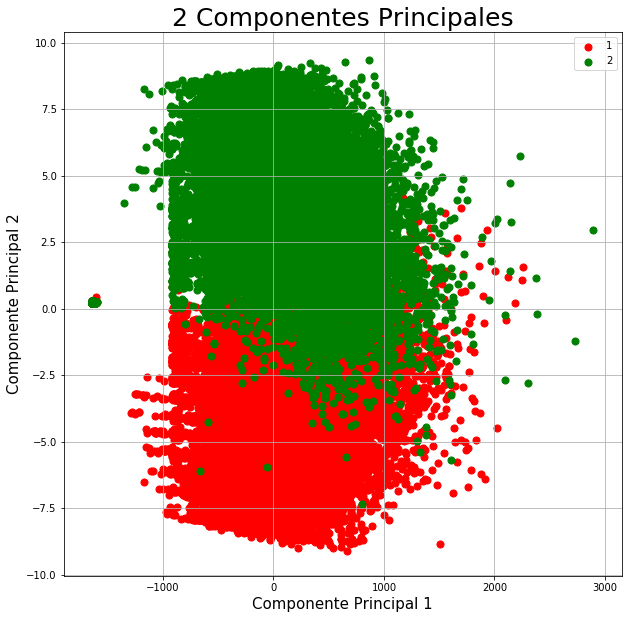

In [13]:
# Esta representación no es la de KMeans, sino la real sobre las dos dimensiones más significativas

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

comp_p = pca.fit_transform(games_ml)
df_pca_2 = pd.DataFrame(data = comp_p, columns = ['Componente Principal 1', 'Componente Principal 2'])

df_pca_2 = pd.concat([df_pca_2, winner_ml], axis = 1)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Componente Principal 1', fontsize = 15)
ax.set_ylabel('Componente Principal 2', fontsize = 15)
ax.set_title('2 Componentes Principales', fontsize = 25)
targets = [1, 2]
colors = ['r', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = df_pca_2.iloc[:, 2] == target
    ax.scatter(df_pca_2.loc[indicesToKeep, 'Componente Principal 1'], df_pca_2.loc[indicesToKeep, 'Componente Principal 2']
               ,c = color ,s = 50)
    
ax.legend(targets)
plt.savefig("imagenes/Plot Kmeans.png")
ax.grid()

Se puede ver una separación medianamente clara entre las partidas, por lo que KMeans debería de obtener unos resultados bastante buenos

                                                                        11) Clustering Espectral

In [14]:
from sklearn.cluster import SpectralClustering

In [15]:
model_spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model_spectral.fit(x_train_sparse, y_train_sparse)

D:\Users\jorge\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


                                                                        12) Clustering Jerárquico

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [17]:
linked = linkage(dataframe_ml_09, 'single')

labelList = range(1, 2)

plt.figure(figsize=(100, 100))  
dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig("imagenes/clustering jerárquico.png")
plt.show()

IndexError: range object index out of range

<Figure size 7200x7200 with 0 Axes>

                                                                        13) Reglas de Asociación

In [ ]:
#import sys
#!{sys.executable} -m pip install apyori

from apyori import apriori

In [ ]:
association_rules = apriori(games, min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=2)  

In [ ]:
list(association_rules)

                                                                        14) Deep Learning

In [ ]:
#import sys
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install tensorflow

from keras.models import Sequential

from keras.layers import Dense

# Inicialización
model = Sequential()

# Input 
model.add(Dense(5, activation='relu', input_shape=(11,)))

# Hidden
model.add(Dense(12, activation='relu'))

# Output
# Sigmoide para que sean porcentajes
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')
                   
model.fit(x_train_sparse, y_train_sparse, epochs=10, batch_size=1, verbose=1)

In [ ]:
y_pred_deep = model.predict(x_test_sparse)

In [ ]:
puntuacion_deep = model.evaluate(x_test_sparse, y_test_sparse, verbose=1)

print(puntuacion_deep)

In [ ]:
confusion_matrix(y_test_sparse, y_pred_sparse)